## Análise preliminar da distribuição dos dados

15 de agosto de 2023

---

Com este notebook, objetiva-se a exploração da distribuição de dados no conjunto ao qual será implementado o algoritmo de k-means. Esta exploração tem caráter preliminar, e deverá apresentar a distribuição de dados, estatísticas e outras informações que nos levem a compreender o insumo que temos.

Em relação ao dataset, parte-se de algumas premissas:

- os dados foram coletados por meio do Portal de Dados Abertos da Alesp, sendo assim registros oficiais;
- os valores foram corrigidos conforme a inflação de cada período até dezembro de 2022, seguindo metodologia do Banco Central e índices disponibilizados pelo IBGE;
- os dados se referem a despesas de alimentação e hospedagem, apenas;
- cada linha é um registro de despesa único.

À análise:

In [1]:
# carregamento das bibliotecas necessárias
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

In [2]:
# carregamento do dataset
df = pd.read_csv("../data/2018_2022_corrigido.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14619 entries, 0 to 14618
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Data             14619 non-null  object 
 1   CNPJ             14127 non-null  float64
 2   Valor_corrigido  14619 non-null  float64
dtypes: float64(2), object(1)
memory usage: 342.8+ KB


O dataset é composto de três colunas (uma do tipo `object` ou `str`; duas do tipo `float`) e 14.619 linhas. `CNPJ` contém alguns valores nulos &mdash; como esta é uma variável importante para a aplicação futura de k-means, valores nulos devem ser desconsiderados. Além disso, é preciso converter `CNPJ` para o tipo `string`, pois trata-se de variável categórica.

In [3]:
# exclusão de nulos
df = df[df['CNPJ'].notnull()]

# conversão de tipo
df['CNPJ'] = df['CNPJ'].astype(str)

Observemos a quantidade de registros por ano:

In [4]:
# cópia do dataframe
df_ano = df.copy()

# conversão de tipo
df_ano['Data'] = pd.to_datetime(df_ano['Data'])

# agrupamento e cálculos
df_ano.groupby(df_ano['Data'].dt.year).agg({'Valor_corrigido': ['sum', 'count', 'mean']})

Valor_corrigido                  
                 sum count        mean
Data                                  
2018       931806.30  3098  300.776727
2019      1047596.58  3403  307.845013
2020       350773.85  1435  244.441707
2021       816510.19  2782  293.497552
2022       988979.78  3409  290.108472

Aqui temos uma informação interessante: no período observado, 2019 foi o ano com maior valor total, mas com quantidade de despesas similar a 2022.

Com os valores deflacionados, a data não mais nos interessa. Vamos tomar apenas duas colunas: `CNPJ` e `Vamor_corrigido`.

In [5]:
# remoção de colunas desnecessárias
data = df[['CNPJ', 'Valor_corrigido']]

# apresentação de resultados
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14127 entries, 0 to 14618
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CNPJ             14127 non-null  object 
 1   Valor_corrigido  14127 non-null  float64
dtypes: float64(1), object(1)
memory usage: 331.1+ KB


In [6]:
# contagem de valores únicos
data['CNPJ'].nunique()

4414

In [7]:
data['Valor_corrigido'].sum()

4135666.7

In [8]:
# descrição estatística dos dados
data['Valor_corrigido'].describe()

count    14127.000000
mean       292.749112
std        681.290247
min          0.000000
25%         54.265000
50%        115.330000
75%        253.330000
max      10250.410000
Name: Valor_corrigido, dtype: float64

Os 14.127 registros mostram que há 4.414 CNPJs únicos. Tais despesas somam R\\$ 4.135.666,70. Cada despesa tem o valor médio de R\\$ 292,75 &mdash; entretanto, o desvio-padrão é elevado, indicando significativa dispersão dos dados em relação à média.

Notamos ainda que a média é superior ao terceiro quartil (Q3). Isso indica que o conjunto de dados está inclinado para valores mais baixos, apesar da significante presença de outliers, que puxa o Q3 para cima. Graficamente, o valor médio maior que o Q3 sugere assimetria positiva: a cauda do lado direito  é mais longa do que do lado esquerdo.

Vamos ver essa dispersão em gráficos:

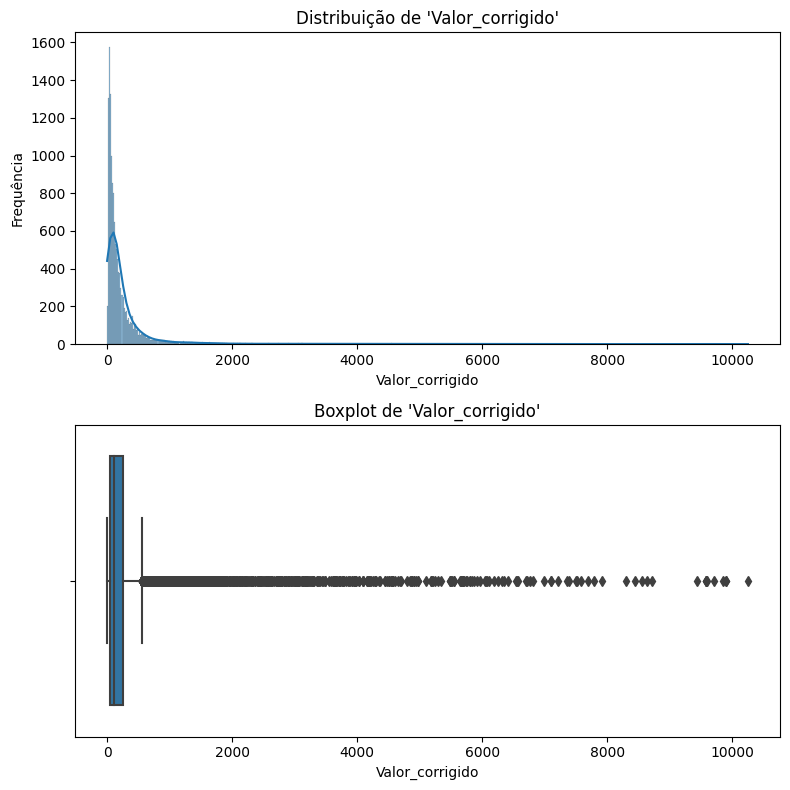

In [9]:
# determinação da disposição dos gráficos
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

# criação de histograma
sns.histplot(data['Valor_corrigido'], kde=True, ax=axes[0])
axes[0].set_title("Distribuição de 'Valor_corrigido'")
axes[0].set_xlabel('Valor_corrigido')
axes[0].set_ylabel('Frequência')

# criação de boxplot
sns.boxplot(x=data['Valor_corrigido'], ax=axes[1])
axes[1].set_title("Boxplot de 'Valor_corrigido'")
axes[1].set_xlabel('Valor_corrigido')

# apresentação
plt.tight_layout()
plt.show()

O histograma mostra que `Valor_corrigido` está inclinado para a direita, com concentração de valores mais baixos: conforme os valores aumentam, a densidade diminui.

Já boxplot confirma a presença de outliers na distribuição. O intervalo interquartil é estreito em comparação com a amplitude de todo o dataset, o que indica que a maioria dos dados se concentra num intervalo pequeno e mais próximo dos menores valores.

Observemos, então, coeficiente de variação, assimetria e curtose.o

In [10]:
# cálculo de coeficiente de variação
cv = data['Valor_corrigido'].std() / data['Valor_corrigido'].mean()

# cálculo de assimetria e curtose
data_skewness = skew(data['Valor_corrigido'])
data_kurtosis = kurtosis(data['Valor_corrigido'])

# organização de resultados
resultados = {
    'coeficiente de variação': cv,
    'assimetria': data_skewness,
    'curtose': data_kurtosis
}

# apresentação
resultados

{'coeficiente de variação': 2.3272154207553792,
 'assimetria': 7.040865107241919,
 'curtose': 64.79066970927987}

O coeficiente de variação de 232,72% indica alto grau de variabilidade relativo à média. A assimetria de 7 confirma a inclinação à direita, enquanto a curtose de 64,8 comprova cauda longa e picos acentuados em comparação à distribuição normal.